In [20]:
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import functions.data_wrangling as data 
import functions.eddy_feedback as ef

# Check OpenIFS Data

In [21]:
mother_path = Path('/home/links/ct715/data_storage/PAMIP/monthly/1.1_pdSST-pdSIC/OpenIFS')
# path_list = ['T1279_epf', 'T1279_U', 'T159_epf', 'T159_U']

# ifs = {}
# for item in path_list:
    
#     # set paths and create list of files
#     nc_path = mother_path / item
#     nc_files = list(nc_path.iterdir())
    
#     # import datasets and save to dict
#     ds = xr.open_mfdataset(
#         nc_files,
#         parallel=True,
#         combine='nested',
#         concat_dim='ens_ax'
#     )
#     ifs[item] = ds

### T159 wrangling

In [22]:
# ifs['T159_U'] = data.change_to_cftime(ifs['T159_U'])
# ifs['T159_U'] = ifs['T159_U'].sel(plev=ifs['T159_epf'].plev)
# ifs['T159_U']

# ifs['T159_epf'] = data.change_to_cftime(ifs['T159_epf'])
# ifs['T159_epf']

# t159 = xr.Dataset({
#     'epfy': ifs['T159_epf'].Fphi,
#     'epfz': ifs['T159_epf'].Fp,
#     'ua': ifs['T159_U'].U
# })

# t159 = ef.calculate_divFphi(t159)
# t159 = data.data_checker1000(t159)
# t159['ubar'] = t159['ua'].mean('lon')
# t159

# save_name = mother_path / 'OpenIFS-T159_EFP.nc'
# t159.to_netcdf(save_name)

In [23]:
t159 = xr.open_mfdataset(
    mother_path / 'OpenIFS-T159_EFP.nc',
    parallel=True
)
t159

<xarray.Dataset>
Dimensions:  (time: 12, lat: 160, level: 13, ens_ax: 300, lon: 320)
Coordinates:
  * time     (time) object 2000-06-01 00:00:00 ... 2001-05-01 00:00:00
  * lat      (lat) float64 -89.44 -88.31 -87.19 -86.06 ... 87.19 88.31 89.44
  * level    (level) float64 1e+03 700.0 500.0 400.0 ... 50.0 30.0 20.0 10.0
  * lon      (lon) float64 0.0 1.125 2.25 3.375 4.5 ... 355.5 356.6 357.8 358.9
Dimensions without coordinates: ens_ax
Data variables:
    epfy     (ens_ax, time, level, lat) float64 dask.array<chunksize=(300, 12, 13, 160), meta=np.ndarray>
    epfz     (ens_ax, time, level, lat) float64 dask.array<chunksize=(300, 12, 13, 160), meta=np.ndarray>
    ua       (ens_ax, time, level, lat, lon) float32 dask.array<chunksize=(300, 12, 13, 160, 320), meta=np.ndarray>
    divFy    (ens_ax, time, level, lat) float64 dask.array<chunksize=(300, 12, 13, 160), meta=np.ndarray>
    ubar     (ens_ax, time, level, lat) float32 dask.array<chunksize=(300, 12, 13, 160), meta=np.ndarray>

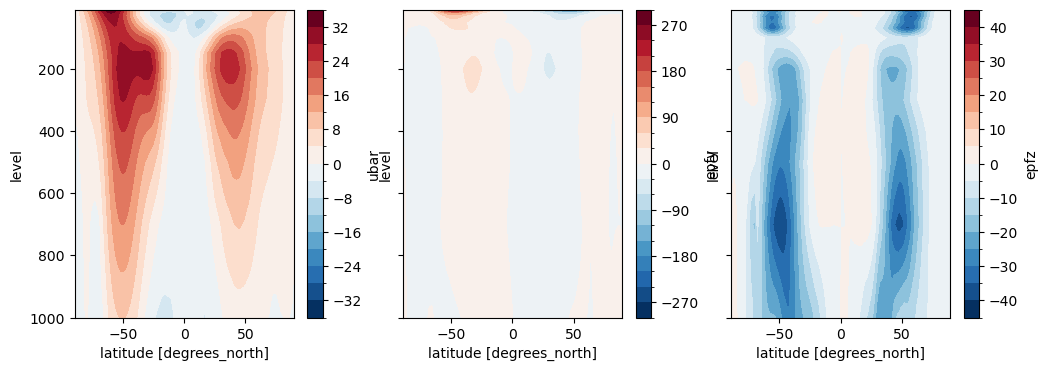

In [24]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(12,4), sharey=True)
t159.ubar.mean(('time', 'ens_ax')).plot.contourf(levels=20, yincrease=False, ax=ax1)
t159.epfy.mean(('time', 'ens_ax')).plot.contourf(levels=20, yincrease=False, ax=ax2)
t159.epfz.mean(('time', 'ens_ax')).plot.contourf(levels=20, yincrease=False, ax=ax3)

### T1279 wrangling

In [25]:
mother_path = Path('/home/links/ct715/data_storage/PAMIP/monthly/1.1_pdSST-pdSIC/OpenIFS')
path_list = ['T1279_epf', 'T1279_U']

ifs = {}
for item in path_list:
    
    # set paths and create list of files
    nc_path = mother_path / item
    nc_files = list(nc_path.iterdir())
    
    # import datasets and save to dict
    ds = xr.open_mfdataset(
        nc_files,
        parallel=True,
        combine='nested',
        concat_dim='ens_ax'
    )
    ifs[item] = ds

Appears that it's just the final month that has an issue. This line shows all normal months with '2001-5' removed:
```
ifs['T1279_U'].U.sel(time=slice('2000-05', '2001-04')).mean(('lon', 'ens_ax')).plot(x="lat", y="plev", col="time", col_wrap=3)
```

Tried showing all ens_ax members but still had crazy value. Here I try different parameters to find the cause

- Not an individual ens member: `corrupt.U.mean('').plot(x='lat', y='plev', col='ens_ax', col_wrap=10)`
    - Neither did an average for plev: `corrupt.U.mean('plev').plot(x='lat', y='lon', col='ens_ax', col_wrap=10)` BUT a warning message did not pop up
    - Neither for lat average. Only one warning message (RunTime)


It's the surface level for time='2001-05'. When the surface is removed for this month we see normal values. Wonder what is best to counteract this?
```
corrupt = ifs['T1279_U'].sel(time='2001-5', plev=slice(92500, 100))
corrupt.U.mean('ens_ax').plot(x='lon', y='lat', col='plev', col_wrap=10)
```

Now let's have a deeper dive. It appears that ensemble 75 could be the issue, Using:
```
corrupt = ifs['T1279_U'].sel(time='2001-5', plev=100000)
corrupt.U.plot(x='lon', y='lat', col='ens_ax', col_wrap=10)
```

/home/links/ct715/miniforge3/envs/eddy/lib/python3.12/site-packages/matplotlib/colors.py:1370: RuntimeWarning: overflow encountered in subtract
  resdat -= vmin
/home/links/ct715/miniforge3/envs/eddy/lib/python3.12/site-packages/matplotlib/colors.py:1370: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


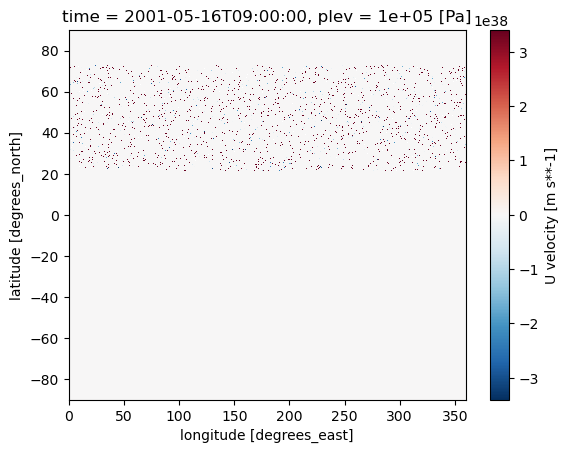

In [26]:
corrupt = ifs['T1279_U'].sel(time='2001-5', plev=100000, ens_ax=75)
# corrupt.U.plot(x='lon', y='lat', col='ens_ax', col_wrap=10)
corrupt.U.plot(x='lon', y='lat')

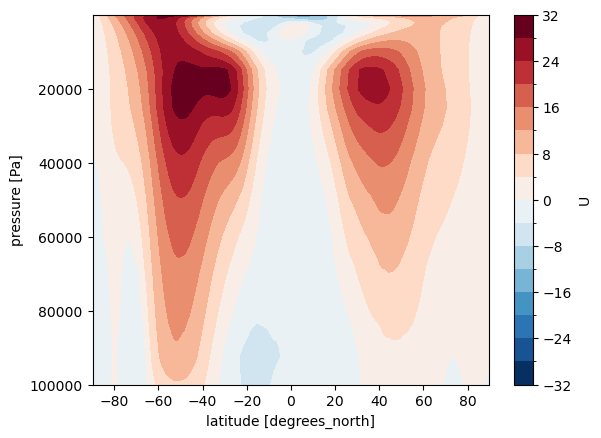

In [27]:
not_corrupted = ifs['T1279_U'].drop_sel(ens_ax=75)
not_corrupted.U.mean(('time', 'ens_ax', 'lon')).plot.contourf(levels=20, yincrease=False)

In [28]:
# # create an array of cftime
# import cftime

# # Start and end months and years
# start_year, start_month = 2000, 6
# end_year, end_month = 2001, 5

# # Generate the cftime array
# cftime_array = [
#     cftime.DatetimeNoLeap(year, month, 1, 0, 0, 0)
#     for year in range(start_year, end_year + 1)
#     for month in range(1, 13)
#     if (year > start_year or month >= start_month) and (year < end_year or month <= end_month)
# ]

# print(cftime_array)
# len(cftime_array)

In [29]:
# ifs['T1279_epf'] = data.change_to_cftime(ifs['T1279_epf'])
# ifs['T1279_epf'] = ifs['T1279_epf'].drop_sel(ens_ax=75)

# ifs['T1279_U'] = ifs['T1279_U'].drop_sel(ens_ax=75)
# ifs['T1279_U'] = ifs['T1279_U'].interp(plev=ifs['T1279_epf'].plev)

# # ifs['T1279_U'] = ifs['T1279_U'].sel(plev=ifs['T1279_epf'].plev)
# ifs['T1279_U'] = ifs['T1279_U'].groupby('time.month').mean()
# ifs['T1279_U'] = ifs['T1279_U'].rename({'month': 'time'})
# ifs['T1279_U']['time'] = cftime_array
# ifs['T1279_U']

# T1279 = xr.Dataset({
#     'epfy': ifs['T1279_epf'].Fphi,
#     'epfz': ifs['T1279_epf'].Fp,
#     'ua': ifs['T1279_U'].U
# })

# T1279 = ef.calculate_divFphi(T1279)
# T1279 = data.data_checker1000(T1279)
# T1279['ubar'] = T1279['ua'].mean('lon')
# T1279

# save_name = mother_path / 'OpenIFS-T1279_EFP.nc'
# T1279.to_netcdf(save_name)

In [30]:
t1279 = xr.open_mfdataset(
    mother_path / 'OpenIFS-T1279_EFP.nc',
    parallel=True
)
t1279

<xarray.Dataset>
Dimensions:  (time: 12, lat: 480, level: 13, ens_ax: 99, lon: 960)
Coordinates:
  * time     (time) object 2000-06-01 00:00:00 ... 2001-05-01 00:00:00
  * lat      (lat) float64 -89.81 -89.44 -89.06 -88.69 ... 89.06 89.44 89.81
  * level    (level) float64 1e+03 700.0 500.0 400.0 ... 50.0 30.0 20.0 10.0
  * lon      (lon) float64 0.0 0.375 0.75 1.125 1.5 ... 358.5 358.9 359.2 359.6
Dimensions without coordinates: ens_ax
Data variables:
    epfy     (ens_ax, time, level, lat) float64 dask.array<chunksize=(99, 12, 13, 480), meta=np.ndarray>
    epfz     (ens_ax, time, level, lat) float64 dask.array<chunksize=(99, 12, 13, 480), meta=np.ndarray>
    ua       (time, ens_ax, level, lat, lon) float32 dask.array<chunksize=(12, 99, 13, 480, 960), meta=np.ndarray>
    divFy    (ens_ax, time, level, lat) float64 dask.array<chunksize=(99, 12, 13, 480), meta=np.ndarray>
    ubar     (time, ens_ax, level, lat) float32 dask.array<chunksize=(12, 99, 13, 480), meta=np.ndarray>

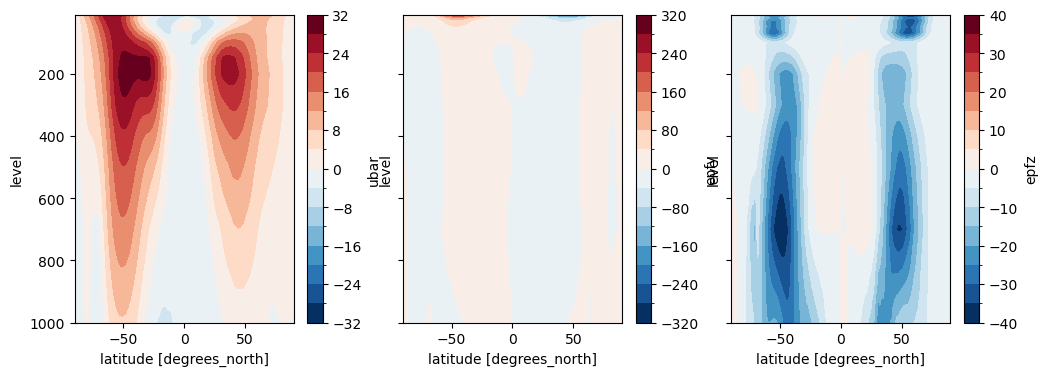

In [31]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(12,4), sharey=True)
t1279.ubar.mean(('time', 'ens_ax')).plot.contourf(levels=20, yincrease=False, ax=ax1)
t1279.epfy.mean(('time', 'ens_ax')).plot.contourf(levels=20, yincrease=False, ax=ax2)
t1279.epfz.mean(('time', 'ens_ax')).plot.contourf(levels=20, yincrease=False, ax=ax3)